## Описание проекта

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Имеются данные до 2016 года. Представим, что сейчас декабрь 2016 г., и планируется кампания на 2017-й.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

<b>Цель:</b> выявить определяющие успешность игры закономерности.

## Загрузка и обработка данных

### Загрузка

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

games = pd.read_csv('games.csv')

In [6]:
games.info()
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Замена названий столбцов

В первую очередь заменим названия столбцов на более удобные для работы

In [7]:
games.columns = list((map(lambda x: x.lower(), games.columns)))
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразование данных к нужным типам

Далее преобразуем данные в нужные типы:

<b>user_score - float</b>

In [8]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Как мы видим, в данном столбце присутствует объект 'tbd', поэтому у столбца тип данных 'object'. 'tbd' означает 'будет решено, определено', соответственно, оценка неизвестна, можем подставить вместо этого значения 'NaN', а потом преобразовать данные в столбце.

In [9]:
games['user_score'] = games['user_score'].replace('tbd', np.nan).astype('float')
games['user_score'].dtype

dtype('float64')

Преобразование типа данных было прозиведено по причине того, что этот столбец означает оценку пользователя в цифрах, а не в строковом формате.

### Обработка пропущенных значений

Этих преобразований типов пока достаточно для дальнейшей работы. 

<b>Перейдем к пропущенным значениям.</b>

Проверим количество пропусков.

In [10]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

#### Столбец 'name'

Начнем по порядку:

<b>'name' - 2 пропущенных значения.</b>

Очевидно, что если мы не знаем название игры, то нет никакого смысла анализировать эти данные, ведь присвоить их будет не к чему. Возможно данные были утеряны.

<b>Удаляем эти данные. </b>

In [11]:
games = games.dropna(axis=0, subset=['name']).reset_index(drop=True)

#### Столбец 'year_of_release'

Можно было бы заменить пропущенные годы выпуска относительно платформе, на которую выпускали игру, но разброс слишком большой (сводная таблица представлена ниже), чтобы угадывать эти данные, <b>поэтому удалим их.</b>

Причиной пропусков вполне возможно могла оказаться утеря данных.

In [12]:
games.pivot_table(index='platform', values='year_of_release', aggfunc=[min, max])

,min,max
,year_of_release,year_of_release
platform,,
2600,1980.0,1989.0
3DO,1994.0,1995.0
3DS,2011.0,2016.0
DC,1998.0,2008.0
DS,1985.0,2013.0
GB,1988.0,2001.0
GBA,2000.0,2007.0
GC,2001.0,2007.0


In [13]:
games = games.dropna(axis=0, subset=['year_of_release']).reset_index(drop=True)

Я удалил эти данные так как в дальнейшем мы будем анализировать игры по годам выпуска, а искаженные данные нам не нужны. Пусть лучше этих игр не будет в списке вовсе.

Теперь мы можем преобразовать тип данных в этом столбце к 'int'

In [14]:
games['year_of_release'] = games['year_of_release'].astype('int')
games['year_of_release'].dtype

dtype('int32')

#### Остальные столбцы

Проверим оставшиеся пропущенные значения.

In [15]:
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

<b>Я считаю, что пропущенные значения в столбцах, которые относятся к "рейтингу" и "отзывам" стоит оставить, потому что мы практически ничего не можем поделать с этими "важными" значениями, кроме как удалить их. Но удалять такое количество данных непозволимо, поэтому оставим их так как есть.</b>

Причиной этих пропусков могла оказаться потеря данных, либо же на время выхода игры не было возможности собрать, например, все отзывы пользователей воедино и составить общий портрет. Игра могла быть слишком старой и на то время не давали рейтинги играм.

### Подсчет суммарных продаж

In [16]:
games['all_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

## Исследовательский анализ данных

<b>Посмотрим, сколько игр выпускалось в разные годы. 
    
Важны ли данные за все периоды?</b>

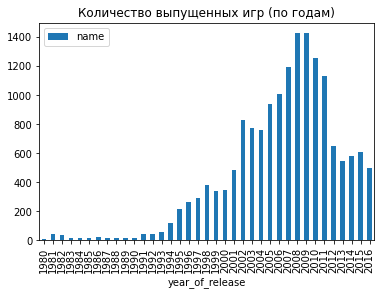

In [17]:
games.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(kind='bar', title='Количество выпущенных игр (по годам)');

In [18]:
games.pivot_table(index='year_of_release', values='name', aggfunc='count')

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


Как мы можем наблюдать в таблице, до 1994 года количество выпущенных игр не доходило даже до 100, в то время как в 2002 году выпустили уже 829 игр, а в 2008 аж 1427 игр.

<b>Основываясь на этом, можно сказать, что данные с 1980 по 1993 гг. являются не такими важными, как за последующие года.</b>

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

<b>Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами (5) и построим распределение по годам. 
    
За какой характерный срок появляются новые и исчезают старые платформы?</b>

In [19]:
games['all_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
platform_sales = games.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values(by='all_sales', ascending=False).head(5)
platform_sales

,all_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78


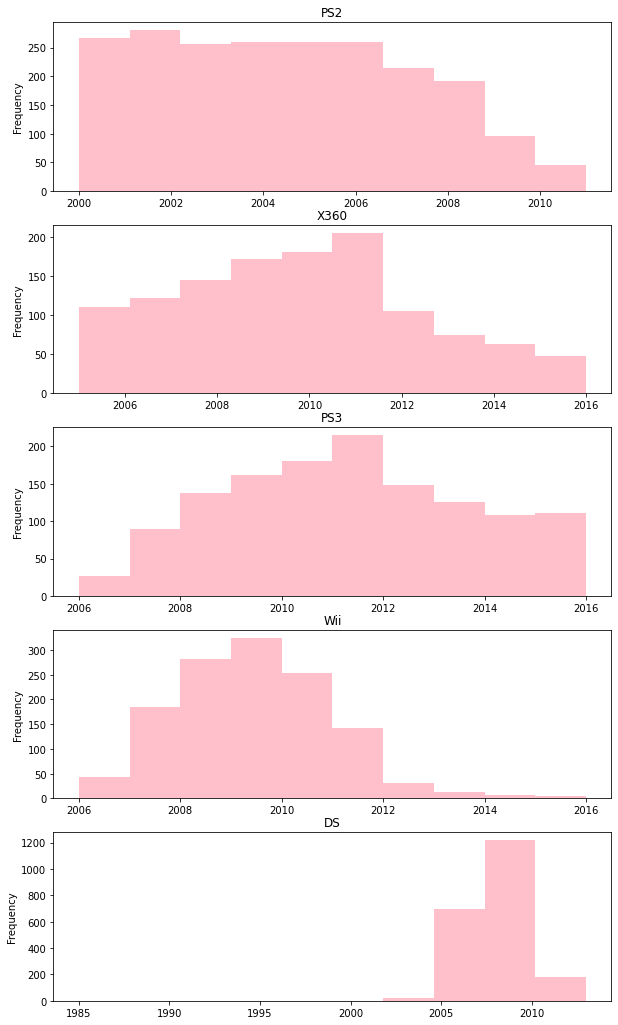

In [20]:
top_platforms = list(platform_sales.index)
fig, axs = plt.subplots(5, 1, figsize=(10, 18))
ax = 0
for platform in top_platforms:
    games.query('platform == @platform')['year_of_release'].plot(kind='hist', title=platform, color='pink', ax = axs[ax]);
    ax += 1

Основываясь на гистограммах распределения, можно заметить, что продолжительность существования платформы на рынке примерно <b>10 лет.</b> Это и есть характерный срок.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

<b>Возьмем данные за соответствующий актуальный период. Актуальный период определим в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.</b>

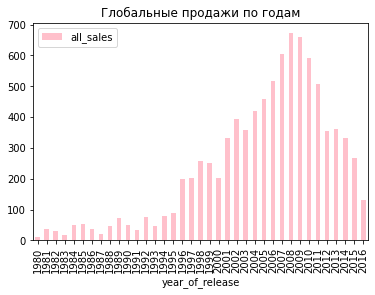

In [21]:
games.pivot_table(index='year_of_release', values='all_sales', aggfunc='sum').plot(kind='bar', color='pink', title='Глобальные продажи по годам');

Основываясь на этой диаграмме можно увидеть, что рынок стабилизировался в 2012 году и последующие года глобальные продажи оставались стабильными, возможно тренды поменялись. 

<b>Возьмем актуальный период с 2012 по 2016 гг.</b>

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

<b>Не будем учитывать в работе данные за предыдущие годы.</b>

In [22]:
games = games.query('year_of_release >= 2012').reset_index(drop=True)
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

<b>Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.</b>

In [23]:
platform_sales = games.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values(by='all_sales', ascending=False).head(10)
platform_sales

,all_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18
Wii,35.37


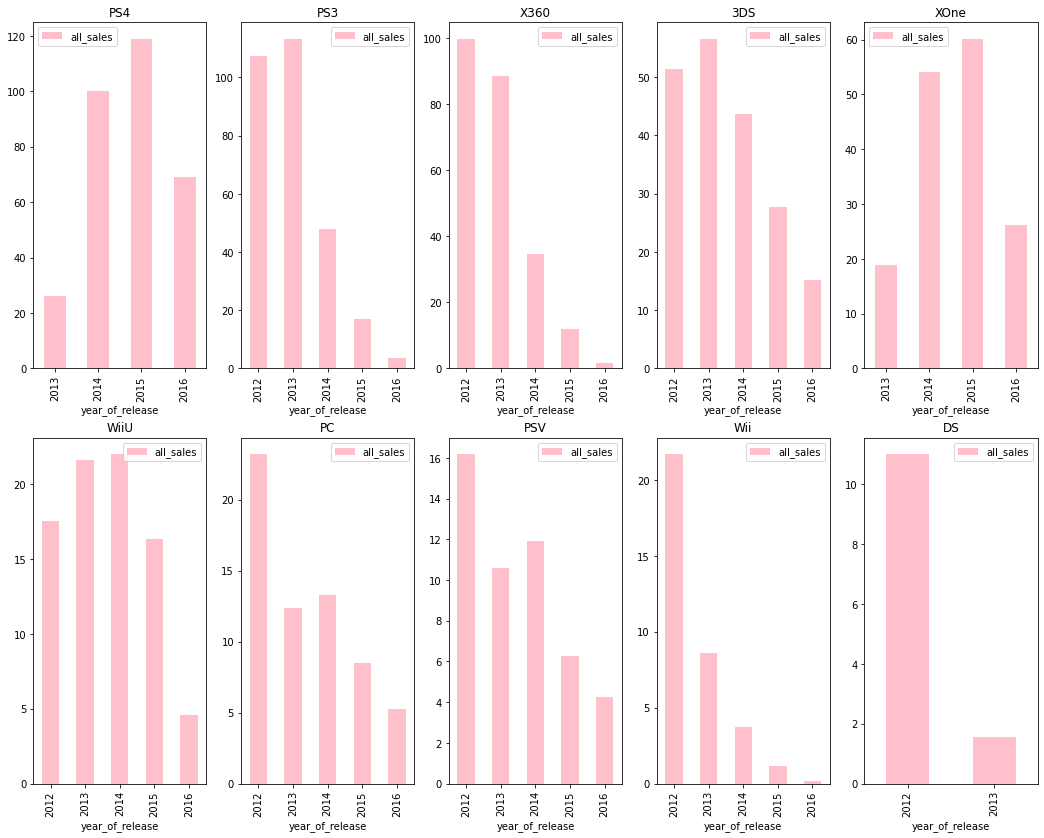

In [24]:
fig, axs = plt.subplots(2, 5, figsize=(18, 14))
ax = ((0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4))
i = 0
top_platforms = list(platform_sales.index)
for platform in top_platforms:
    games.query('platform == @platform').pivot_table(index='year_of_release', values='all_sales', aggfunc='sum').plot(kind='bar', title=platform, color='pink', ax=axs[ax[i]]);
    i += 1

Основываясь на графиках, можно заметить, что продажи большинства лидирующих платформ стремительно снижаются с каждым годом, но исключениями являются платформы <b>PS4, XOne</b> так как они самые новые и лидирующие по характеристикам. Также на плаву остается и 3DS.

<b>Потенциально прибыльные платформы:</b>

    PS4
    Xbox One
    3DS

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

<b>Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.</b>

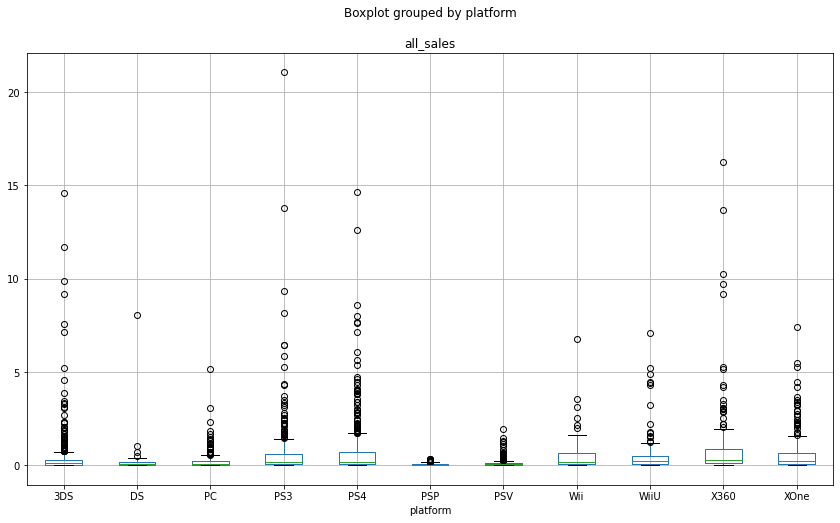

In [25]:
import warnings
warnings.filterwarnings('ignore')

games.boxplot(column='all_sales', by='platform', figsize=(14, 8));

Основываясь на графиках можно сделать следующие выводы:

- Глобальные продажи игр на всех платформах в основном не превышают 1 млн. копий

- Многие платформы имеют выбросы, эти игры можно назвать хитами

- Наибольший выброс присутствует у платформы PS3, одна игра разошлась в тираже больше 20 млн. копий

- Платформа PSP не прославилась большим количеством выбросов или бестселлеров

- Основные платформы, где больше всего бестселлеров (выбросов): 3DS, PS3, PS4, Xbox 360, Xbox One

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

<b>Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы.</b>

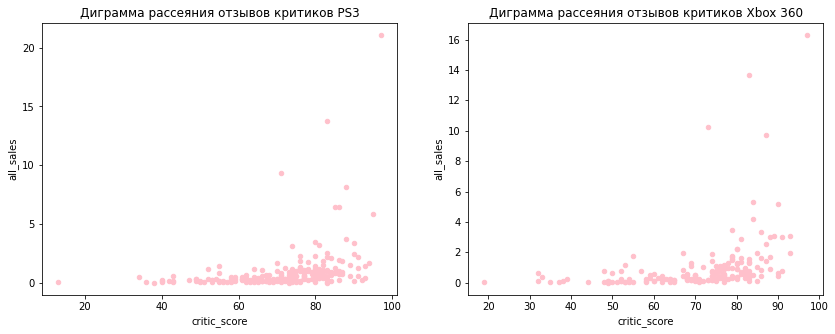

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
games.query('platform == "PS3"').plot(kind='scatter', x='critic_score', y='all_sales', title='Диграмма рассеяния отзывов критиков PS3', color='pink', ax=axs[0]);
games.query('platform == "X360"').plot(kind='scatter', x='critic_score', y='all_sales', title='Диграмма рассеяния отзывов критиков Xbox 360', color='pink', ax=axs[1]);

In [27]:
print('Корреляция между отзывами пользователей и глобальными продажами PS3: {:.3f}'.format(
games.query('platform == "PS3"')['user_score'].corr(
    games.query('platform == "PS3"')['all_sales']
    )))
print()
print('Корреляция между отзывами критиков и глобальными продажами PS3: {:.3f}'.format(
games.query('platform == "PS3"')['critic_score'].corr(
    games.query('platform == "PS3"')['all_sales']
    )))


Корреляция между отзывами пользователей и глобальными продажами PS3: -0.005

Корреляция между отзывами критиков и глобальными продажами PS3: 0.331


- Судя по всему, отзывы пользователей слабо влияют на глобальные продажи игр, а <b>отзывы критиков достаточно сильно влияют на глобальные продажи, это вполне логично</b>


- Большинство игр имеют оценку выше 5 (по 10 бальной шкале) и выше 50 (по 100 бальной шкале)

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

<b>Соотнесем выводы с продажами игр на других платформах.</b>

Рассмотрим влияют ли также отзывы критиков на глобальные продажи игр на другие платформы.

In [28]:
print('Корреляция между отзывами пользователей и глобальными продажами X360: {:.3f}'.format(
games.query('platform == "X360"')['user_score'].corr(
    games.query('platform == "X360"')['all_sales']
    )))
print('Корреляция между отзывами критиков и глобальными продажами X360: {:.3f}'.format(
games.query('platform == "X360"')['critic_score'].corr(
    games.query('platform == "X360"')['all_sales']
    )))
print()
print('Корреляция между отзывами пользователей и глобальными продажами PS4: {:.3f}'.format(
games.query('platform == "PS4"')['user_score'].corr(
    games.query('platform == "PS4"')['all_sales']
    )))
print('Корреляция между отзывами критиков и глобальными продажами PS4: {:.3f}'.format(
games.query('platform == "PS4"')['critic_score'].corr(
    games.query('platform == "PS4"')['all_sales']
    )))
print()
print('Корреляция между отзывами пользователей и глобальными продажами Xbox One: {:.3f}'.format(
games.query('platform == "XOne"')['user_score'].corr(
    games.query('platform == "XOne"')['all_sales']
    )))
print('Корреляция между отзывами критиков и глобальными продажами Xbox One: {:.3f}'.format(
games.query('platform == "XOne"')['critic_score'].corr(
    games.query('platform == "XOne"')['all_sales']
    )))

Корреляция между отзывами пользователей и глобальными продажами X360: 0.006
Корреляция между отзывами критиков и глобальными продажами X360: 0.361

Корреляция между отзывами пользователей и глобальными продажами PS4: -0.032
Корреляция между отзывами критиков и глобальными продажами PS4: 0.407

Корреляция между отзывами пользователей и глобальными продажами Xbox One: -0.069
Корреляция между отзывами критиков и глобальными продажами Xbox One: 0.417


Корреляция на самых популярных платформах практически одинаковая.

Теперь рассмотрим рассеяние оценок для других платформ.

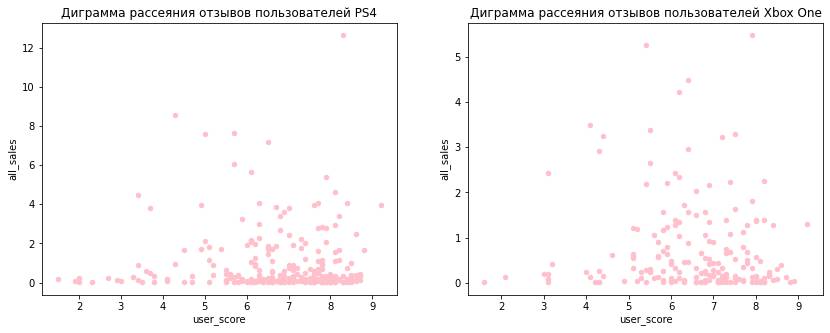

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
games.query('platform == "PS4"').plot(kind='scatter', x='user_score', y='all_sales', title='Диграмма рассеяния отзывов пользователей PS4', color='pink', ax=axs[0]);
games.query('platform == "XOne"').plot(kind='scatter', x='user_score', y='all_sales', title='Диграмма рассеяния отзывов пользователей Xbox One', color='pink', ax=axs[1]);

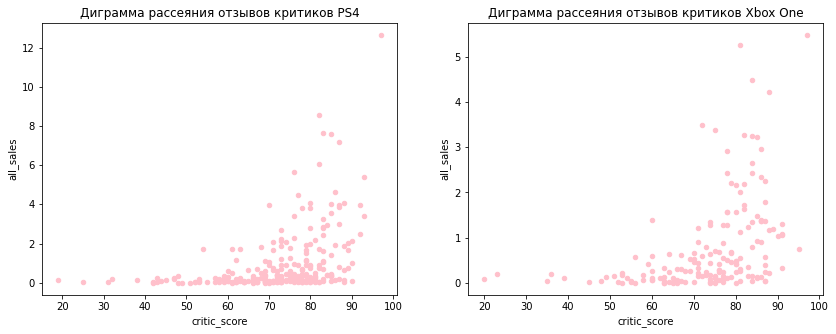

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
games.query('platform == "PS4"').plot(kind='scatter', x='critic_score', y='all_sales', title='Диграмма рассеяния отзывов критиков PS4', color='pink', ax=axs[0]);
games.query('platform == "XOne"').plot(kind='scatter', x='critic_score', y='all_sales', title='Диграмма рассеяния отзывов критиков Xbox One', color='pink', ax=axs[1]);

Опять же у большинства игр оценка выше 5 по 10 бальной шкале и выше 50 по 100 бальной шкале.

Выводы соответствуют и другим платформам.

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

<b>Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?</b>

              count
genre              
Action         1031
Role-Playing    370
Adventure       302
Sports          268
Shooter         235
Misc            192
Racing          115
Fighting        109
Platform         85
Simulation       80
Strategy         71
Puzzle           28


              income
genre               
Action        441.12
Shooter       304.73
Role-Playing  192.80
Sports        181.07
Misc           85.04
Platform       61.00
Racing         53.50
Fighting       44.49
Simulation     35.12
Adventure      29.43
Strategy       13.34
Puzzle          4.89


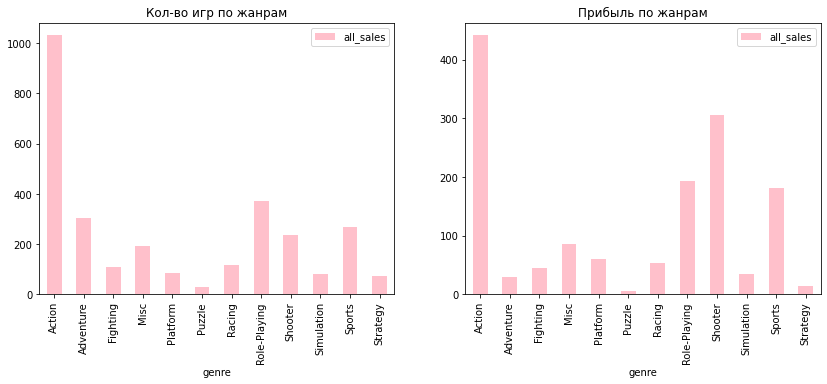

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
games.pivot_table(index='genre', values='all_sales', aggfunc='count').plot(kind='bar', color='pink', title='Кол-во игр по жанрам', ax=axs[0]);
games.pivot_table(index='genre', values='all_sales', aggfunc='sum').plot(kind='bar', color='pink', title='Прибыль по жанрам', ax=axs[1]);

count_genres = games.pivot_table(index='genre', values='all_sales', aggfunc='count').sort_values(by='all_sales', ascending=False)
income_genres = games.pivot_table(index='genre', values='all_sales', aggfunc='sum').sort_values(by='all_sales', ascending=False)
count_genres.columns = ['count']
income_genres.columns = ['income']
print(count_genres, end='\n\n\n')
print(income_genres)

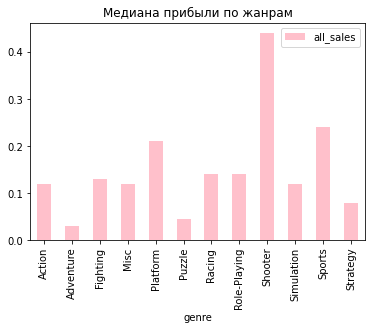

In [32]:
games.pivot_table(index='genre', values='all_sales', aggfunc='median').plot(kind='bar', color='pink', title='Медиана прибыли по жанрам');

Жанр Shooter лидирует по медиане глобальных продаж. А жанр Action спустился на 4-е место по этому показателю.

<b>Самый прибыльный жанр: 
    Shooter</b>

<b>Наибольшее количество игр жанра: 
    Action</b>

<b>Топ 5 прибыльных жанров:
    
    Action
    Shooter
    Sports
    Misc
    Role-Playing</b>
    
<b>Топ 5 жанров по количеству игр:
    
    Action
    Misc
    Sports
    Adventure
    Role-Playing
    
Что можно сказать о самых прибыльных жанрах?:
    
    Самые прибыльные жанры: Action, Shooter, Sports. Это вполне логично, ведь это соответствует интересам людей и в реальной жизни, пользователям хочется действий, экшена, пострелять, побегать, поучавствовать в глобальном спортивном соревновании и тому подобное.
    
Выделяются ли жанры с высокими и низкими продажами?:
    
    Можно сказать, что самый прибыльный жанр Action достаточно сильно выделяется на фоне других, прибыль этого жанра в 1.5 раза больше, чем от следующего по прибыли жанра. Это происходит по причине того, что игр в жанре Action было выпущено в 2 раза больше, чем следующего по количеству игр жанра. Но если посмотреть на медианные значения, то прибыльным жанром является Shooter.
    
    Жанр с самой низкой прибылью: Puzzle. Его продажи с 2012 года составили всего 4.89 единиц, что является очень низким показателем. 

<b>------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):


- Самые популярные платформы (топ-5). Опишем различия в долях продаж.
- Самые популярные жанры (топ-5). Поясним разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

<b>Самые популярные платформы (топ-5). Опишем различия в долях продаж.</b>

,Sales in North America,% of North America sales,Sales in Europe,% of Europe sales,Sales in Japan,% of Japan sales
platform,,,,,,
X360,140.050000,27.98%,74.520000,17.88%,Not in Top-5,Not in Top-5
PS4,108.740000,21.72%,141.090000,33.86%,15.960000,9.22%
PS3,103.380000,20.65%,106.860000,25.64%,35.290000,20.39%
XOne,93.120000,18.6%,51.590000,12.38%,Not in Top-5,Not in Top-5
3DS,55.310000,11.05%,42.640000,10.23%,87.790000,50.72%
PSV,Not in Top-5,Not in Top-5,Not in Top-5,Not in Top-5,21.040000,12.16%
WiiU,Not in Top-5,Not in Top-5,Not in Top-5,Not in Top-5,13.010000,7.52%


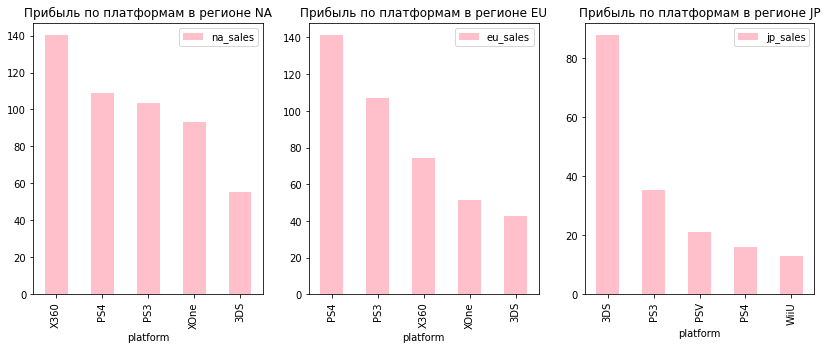

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
top_platforms_na = games.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
top_platforms_eu = games.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
top_platforms_jp = games.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
top_platforms_na['% of NA sales'] = round((top_platforms_na['na_sales'] / top_platforms_na['na_sales'].sum() * 100), 2).astype(str) + '%'
top_platforms_eu['% of EU sales'] = round((top_platforms_eu['eu_sales'] / top_platforms_eu['eu_sales'].sum() * 100), 2).astype(str) + '%'
top_platforms_jp['% of JP sales'] = round((top_platforms_jp['jp_sales'] / top_platforms_jp['jp_sales'].sum() * 100), 2).astype(str) + '%'
top_platforms_na.plot(kind='bar', color='pink', title='Прибыль по платформам в регионе NA', ax = axs[0]);
top_platforms_eu.plot(kind='bar', color='pink', title='Прибыль по платформам в регионе EU', ax = axs[1]);
top_platforms_jp.plot(kind='bar', color='pink', title='Прибыль по платформам в регионе JP', ax = axs[2]);
top_platforms = top_platforms_na.merge(top_platforms_eu, how='outer', on='platform').merge(top_platforms_jp, how='outer', on='platform')
top_platforms.columns = ['Sales in North America', '% of North America sales', 'Sales in Europe', '% of Europe sales', 'Sales in Japan', '% of Japan sales']
top_platforms = top_platforms.fillna('Not in Top-5')

top_platforms.style.set_table_styles(
   [{
       'selector': 'th',
       'props': [('background-color', 'pink')]
   }])

In [34]:
top_platforms_na

,na_sales,% of NA sales
platform,,
X360,140.05,27.98%
PS4,108.74,21.72%
PS3,103.38,20.65%
XOne,93.12,18.6%
3DS,55.31,11.05%


In [35]:
top_platforms_eu

,eu_sales,% of EU sales
platform,,
PS4,141.09,33.86%
PS3,106.86,25.64%
X360,74.52,17.88%
XOne,51.59,12.38%
3DS,42.64,10.23%


In [36]:
top_platforms_jp

,jp_sales,% of JP sales
platform,,
3DS,87.79,50.72%
PS3,35.29,20.39%
PSV,21.04,12.16%
PS4,15.96,9.22%
WiiU,13.01,7.52%


<b>Вывод:</b> В регионах NA и EU рынок разделили практически на равные между собой части консоли: PS3, Xbox 360, Wii. В регионе JP 1-е и 2-е место по прибыли занимают платформы DS и 3DS, переносные маленькие консоли, а за ними идет консоль PS3.

В регионе JP наиболее популярны переносные игровые платформы

В регионе NA и EU наиболее популярны консольные платформы

-----------------------------------------------------------------------------------------------------------------------

<b>Самые популярные жанры (топ-5). Поясним разницу.</b>

,Sales in North America,% of North America sales,Sales in Europe,% of Europe sales,Sales in Japan,% of Japan sales
genre,,,,,,
Action,177.840000,35.12%,159.340000,38.15%,52.800000,34.98%
Shooter,144.770000,28.59%,113.470000,27.16%,Not in Top-5,Not in Top-5
Sports,81.530000,16.1%,69.090000,16.54%,Not in Top-5,Not in Top-5
Role-Playing,64.000000,12.64%,48.530000,11.62%,65.440000,43.35%
Misc,38.190000,7.54%,Not in Top-5,Not in Top-5,12.860000,8.52%
Racing,Not in Top-5,Not in Top-5,27.290000,6.53%,Not in Top-5,Not in Top-5
Simulation,Not in Top-5,Not in Top-5,Not in Top-5,Not in Top-5,10.410000,6.9%
Fighting,Not in Top-5,Not in Top-5,Not in Top-5,Not in Top-5,9.440000,6.25%


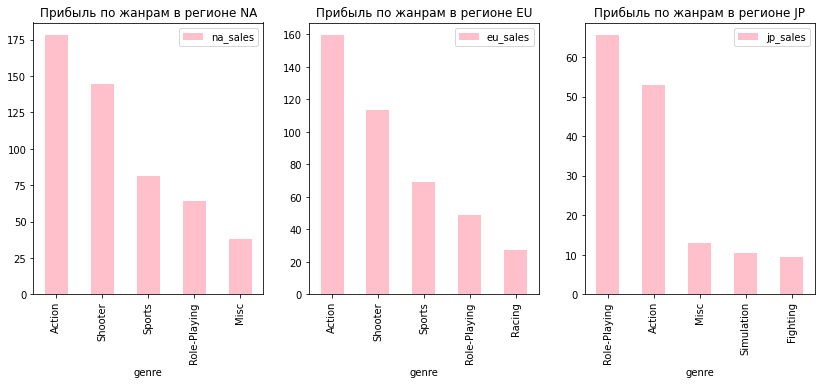

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
income_genres_na = games.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
income_genres_eu = games.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
income_genres_jp = games.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
income_genres_na['% of NA sales'] = round((income_genres_na['na_sales'] / income_genres_na['na_sales'].sum() * 100), 2).astype(str) + '%'
income_genres_eu['% of EU sales'] = round((income_genres_eu['eu_sales'] / income_genres_eu['eu_sales'].sum() * 100), 2).astype(str) + '%'
income_genres_jp['% of JP sales'] = round((income_genres_jp['jp_sales'] / income_genres_jp['jp_sales'].sum() * 100), 2).astype(str) + '%'
income_genres_na.plot(kind='bar', color='pink', title='Прибыль по жанрам в регионе NA', ax = axs[0]);
income_genres_eu.plot(kind='bar', color='pink', title='Прибыль по жанрам в регионе EU', ax = axs[1]);
income_genres_jp.plot(kind='bar', color='pink', title='Прибыль по жанрам в регионе JP', ax = axs[2]);
income_genres = income_genres_na.merge(income_genres_eu, how='outer', on='genre').merge(income_genres_jp, how='outer', on='genre')
income_genres.columns = ['Sales in North America', '% of North America sales', 'Sales in Europe', '% of Europe sales', 'Sales in Japan', '% of Japan sales']
income_genres = income_genres.fillna('Not in Top-5')

income_genres.style.set_table_styles(
   [{
       'selector': 'th',
       'props': [('background-color', 'pink')]
   }])

In [38]:
income_genres_na

,na_sales,% of NA sales
genre,,
Action,177.84,35.12%
Shooter,144.77,28.59%
Sports,81.53,16.1%
Role-Playing,64.00,12.64%
Misc,38.19,7.54%


In [39]:
income_genres_eu

,eu_sales,% of EU sales
genre,,
Action,159.34,38.15%
Shooter,113.47,27.16%
Sports,69.09,16.54%
Role-Playing,48.53,11.62%
Racing,27.29,6.53%


In [40]:
income_genres_jp

,jp_sales,% of JP sales
genre,,
Role-Playing,65.44,43.35%
Action,52.80,34.98%
Misc,12.86,8.52%
Simulation,10.41,6.9%
Fighting,9.44,6.25%


<b>Вывод:</b> 

В регионах NA и EU наиболее популярные жанры: Action, Shooter, Sports

В регионе JP все меняется, наиболее популярные жанры: Role-Playing, Action, Misc

Основная разница приходится на жанр <b>'Role-Playing'</b>. В регионах NA и EU данный жанр даже не входит в топ-5 жанров, в то время как в регионе JP этот жанр стоит на 1-м месте в топ-5. Также в регионе JP жанр <b>'Adventure'</b> почитают намного больше, чем в регионах NA и EU.

-----------------------------------------------------------------------------------------------------------------------

<b>Влияет ли рейтинг ESRB на продажи в отдельном регионе?</b>

In [41]:
games['rating'].unique()

array(['M', nan, 'E', 'E10+', 'T'], dtype=object)

Источник: https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board

«EC» («Early childhood») — «Для детей младшего возраста»;

«E» («Everyone») — «Для всех»;

«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»;

«T» («Teen») — «Подросткам»;

«M» («Mature») — «Для взрослых»;

«RP» («Rating Pending») — «Рейтинг ожидается».

<b>Проведем категоризацию данных.</b>

In [42]:
for row in range(games.shape[0]):
    if games.loc[row, 'rating'] == 'EC':
        games.loc[row, 'esrb'] = '"Для детей младшего возраста"'
    elif games.loc[row, 'rating'] == 'E':
        games.loc[row, 'esrb'] = '"Для всех"'
    elif games.loc[row, 'rating'] == 'E10':
        games.loc[row, 'esrb'] = '"Для всех от 10 лет и старше"'
    elif games.loc[row, 'rating'] == 'T':
        games.loc[row, 'esrb'] = '"Для подростков"'
    elif games.loc[row, 'rating'] == 'M':
        games.loc[row, 'esrb'] = '"Для взрослых"'
    elif games.loc[row, 'rating'] == 'RP':
        games.loc[row, 'esrb'] = '"Рейтинг ожидается"'
    elif pd.isna(games.loc[row, 'rating']):
        games.loc[row, 'esrb'] = '"Нет рейтинга"'
        
games['esrb'].head()

0    "Для взрослых"
1    "Для взрослых"
2    "Нет рейтинга"
3    "Нет рейтинга"
4    "Для взрослых"
Name: esrb, dtype: object

Категоризация данных проведена, теперь визуализируем результат.

,Sales in North America,% of North America sales,Sales in Europe,% of Europe sales,Sales in Japan,% of Japan sales
esrb,,,,,,
"""Для взрослых""",231.570000,44.94%,193.960000,42.96%,21.200000,11.5%
"""Для всех""",114.370000,22.2%,113.030000,25.04%,28.330000,15.36%
"""Нет рейтинга""",103.310000,20.05%,91.500000,20.27%,108.840000,59.03%
"""Для подростков""",66.020000,12.81%,52.960000,11.73%,26.020000,14.11%


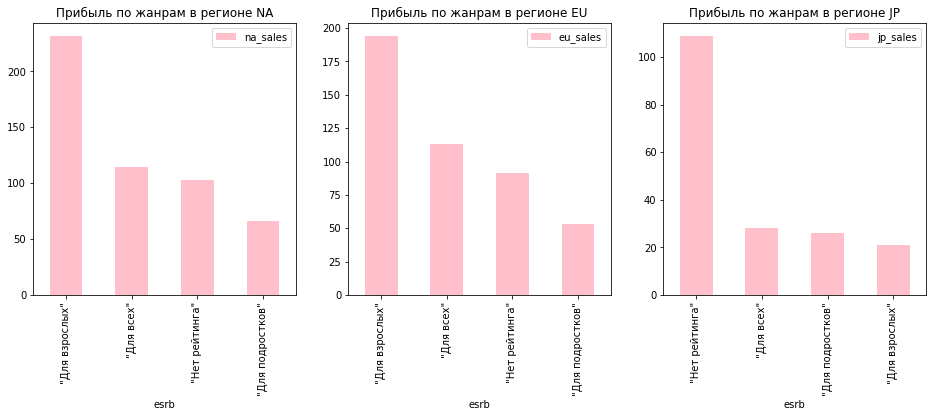

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
esrb_na = games.pivot_table(index='esrb', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
esrb_eu = games.pivot_table(index='esrb', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
esrb_jp = games.pivot_table(index='esrb', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
esrb_na['% of NA sales'] = round((esrb_na['na_sales'] / esrb_na['na_sales'].sum() * 100), 2).astype(str) + '%'
esrb_eu['% of EU sales'] = round((esrb_eu['eu_sales'] / esrb_eu['eu_sales'].sum() * 100), 2).astype(str) + '%'
esrb_jp['% of JP sales'] = round((esrb_jp['jp_sales'] / esrb_jp['jp_sales'].sum() * 100), 2).astype(str) + '%'
esrb_na.plot(kind='bar', color='pink', title='Прибыль по жанрам в регионе NA', ax = axs[0]);
esrb_eu.plot(kind='bar', color='pink', title='Прибыль по жанрам в регионе EU', ax = axs[1]);
esrb_jp.plot(kind='bar', color='pink', title='Прибыль по жанрам в регионе JP', ax = axs[2]);
esrb = esrb_na.merge(esrb_eu, how='outer', on='esrb').merge(esrb_jp, how='outer', on='esrb')
esrb.columns = ['Sales in North America', '% of North America sales', 'Sales in Europe', '% of Europe sales', 'Sales in Japan', '% of Japan sales']

esrb.style.set_table_styles(
   [{
       'selector': 'th',
       'props': [('background-color', 'pink')]
   }])

In [44]:
esrb_na

,na_sales,% of NA sales
esrb,,
"""Для взрослых""",231.57,44.94%
"""Для всех""",114.37,22.2%
"""Нет рейтинга""",103.31,20.05%
"""Для подростков""",66.02,12.81%


In [45]:
esrb_eu

,eu_sales,% of EU sales
esrb,,
"""Для взрослых""",193.96,42.96%
"""Для всех""",113.03,25.04%
"""Нет рейтинга""",91.50,20.27%
"""Для подростков""",52.96,11.73%


In [46]:
esrb_jp

,jp_sales,% of JP sales
esrb,,
"""Нет рейтинга""",108.84,59.03%
"""Для всех""",28.33,15.36%
"""Для подростков""",26.02,14.11%
"""Для взрослых""",21.20,11.5%


<b>Вывод:</b> В регионах NA и EU по продажам лидируют игры, которые обозначены рейтингом "Для взрослых". В регионе NA, EU и JP 2-е место занимает рейтинг "Для всех". В регионе JP 1-е место занимают игры с отсутствующим рейтингом с долей 59%. Видимо в регионе JP игры реже подвергаются присвоению рейтингов, или же в Японии популярны те игры, которым не присваивают рейтинги ESRB.

## Проверка гипотез

Главная цель проекта: выявить определяющие успех игры закономерности.

Для начала проверим различия пользовательских рейтингов популярных платформ: Xbox One и PC.

Составим нулевую гипотезу: 
    
H0 - Средние пользовательские рейтинги платформ Xbox One и PC <b>одинаковые</b>

Соответственно, альтернативная гипотеза будет выглядеть следующим образом:

H1 - Средние пользовательские рейтинги платформ Xbox One и PC <b>не одинаковые</b>

Проверим следующие гипотезы:

    H0 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
    H1 - Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые.
    
Для проверки гипотез используем t-критерий Стьюдента, так как он чаще всего используется для проверки гипотез о равности средних значений в двух выборках. Пороговое значение уровня значимости зададим 0.05

In [52]:
# Выберем только те игры, где пользовательский рейтинг не равняется NaN

games_xone = games[(games['platform'] == 'XOne') * (games['user_score'].isnull() == False)]
games_pc = games[(games['platform'] == 'PC') * (games['user_score'].isnull() == False)]

alpha = 0.05

result = st.ttest_ind(games_xone['user_score'], games_pc['user_score'])

print('p-значение: {}'.format(result.pvalue))

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу не удалось')

p-значение: 0.5535080500643661
Отвергнуть нулевую гипотезу не удалось


<b>Вывод:</b> Отвергнуть нулевую гипотезу не удалось, соответственно, <b>есть основания полагать, что "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые".</b>

--------------------------------------------------------------------------------------------------------------------------

Далее проверим различия пользовательских рейтингов среди популярных жанров: Action и Sports.

Составим нулевую гипотезу: 
    
H0 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») <b>разные.</b>

Соответственно, альтернативная гипотеза будет выглядеть следующим образом:

H1 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») <b>не разные.</b>

Проверим следующие гипотезы:

    H0 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
    H1 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») не разные.

In [55]:
games_action = games[(games['genre'] == 'Action') & (games['user_score'].isnull() == False)]
games_sports = games[(games['genre'] == 'Sports') & (games['user_score'].isnull() == False)]

alpha = 0.05

result = st.ttest_ind(games_action['user_score'], games_sports['user_score'])

print('p-значение: {}'.format(result.pvalue))

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу не удалось')

p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


Уровень значимости получился: 1.08 * 10 ** -12

Соответственно, <b>есть основания полагать, что "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») не разные".</b>

## Общий вывод

<b>1.</b> Изначально, в данных имелись пропущенные значения в столбцах: 'name', 'genre', 'year_of_release', 'critic_score', 'user_score', 'rating'. Мы избавились от пропущенных значений в столбцах 'name', 'genre', 'year_of_release' путем удаления этих данных. А в столбцах 'critic_score', 'user_score', 'rating' мы оставили пропущенные значения.

-------------------------------------------------------------------------------------------------------------------------------

<b>2.</b> Далее мы подсчитали суммарные продажи во всем мире для дальнейшего анализа данных.

-------------------------------------------------------------------------------------------------------------------------------

<b>3.</b> После проведения исследовательского анализа данных мы смогли сделать следующие выводы:

- Данные с 1980 по 1993 гг. являются не такими важными, как за последующие года;


- Продолжительность существования платформы на рынке примерно <b>10 лет;</b>


- Актуальный период для данных, которые помогут построить прогноз на 2017 год: <b>2012-2016 гг;</b>


- Потенциально прибыльные платформы: <b>PS4, Xbox One, 3DS;</b>


- Основываясь на "ящиках с усами":

    - Глобальные продажи игр на всех платформах в основном не превышают 1 млн. копий

    - Многие платформы имеют выбросы, эти игры можно назвать хитами

    - Наибольший выброс присутствует у платформы PS3, одна игра разошлась в тираже больше 20 млн. копий

    - Платформа PSP не прославилась большим количеством выбросов или бестселлеров

    - Основные платформы, где больше всего бестселлеров (выбросов): 3DS, PS3, PS4, Xbox 360, Xbox One
    
    
- Отзывы пользователей слабо влияют на глобальные продажи игр, а <b>отзывы критиков достаточно сильно влияют на глобальные продажи, это вполне логично</b>;


- Глобальные продажи игр на PS3 могут доходить до 20 единиц, но это редкие случаи;


- Большинство игр имеют оценку выше 5 (по 10 бальной шкале) и выше 50 (по 100 бальной шкале);

- Самый прибыльный жанр: Shooter

- Наибольшее количество игр жанра: Action

- <b>Топ 5 прибыльных жанров:
    
        
        Action
        Shooter
        Sports
        Misc
        Role-Playing</b>
    
- <b>Топ 5 жанров по количеству игр:
    
    
        Action
        Misc
        Sports
        Adventure
        Role-Playing
    
-------------------------------------------------------------------------------------------------------------------------------

<b>4.</b> При составлении портрета пользователя каждого региона были сделаны следующие выводы:
    
- В регионе JP наиболее популярны переносные игровые платформы;

    
- В регионе NA и EU наиболее популярны консольные платформы;
    
    
- В регионах NA и EU наиболее популярные жанры: Action, Shooter, Sports;

    
- В регионе JP все меняется, наиболее популярные жанры: Role-Playing, Action, Misc;


- В регионе NA и EU по продажам лидируют игры, которые обозначены рейтингом "Для взрослых";
    
    
- В регионе JP по продажам лидируют игры, которые не обозначены рейтингом.
    
-------------------------------------------------------------------------------------------------------------------------------
    
<b>5.</b> Проверка гипотез показала, что:
    

- есть основания полагать, что "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые";
    
    
- есть основания полагать, что "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») не разные".
    
-------------------------------------------------------------------------------------------------------------------------------
    
<b>Общий вывод:</b> 
    
Я считаю, что успешная игра в 2017 году должна быть выпущена на платформы: PS4, Xbox One, 3DS и принадлежать одному из жанров: Action, Shooter, Sports, а также должна получить рейтинг ESRB - "Для взрослых", "Для всех" или не иметь рейтинга ESRB вовсе.